In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset


/Users/aminebelghmi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Load your dataset
dataset_path = 'chessreaderdata/prediciton.csv'
prediction = pd.read_csv(dataset_path)

In [4]:
import pandas as pd
import os

# Assuming you have a DataFrame called 'predictions' with a 'id' column
# and a folder with image paths called 'chessreaderdata/images'

# Extracting IDs from image paths
image_folder_path = 'chessreaderdata/images'
image_files = os.listdir(image_folder_path)

# Extracting IDs from file names and sorting them
id_list = sorted([int(os.path.splitext(file)[0]) for file in image_files])

# Creating a mapping between the original 'id' column values and the new IDs
id_mapping = dict(zip(prediction['id'], id_list))

# Reindexing the 'id' column in the DataFrame based on the new IDs
prediction['id'] = prediction['id'].map(id_mapping)

# Now, the 'id' column in 'predictions' is modified to match the image IDs


In [5]:
prediction

,id,gameId,turnNumber,number,move_state,confidence,gl,gl2,az,rk,ab,prediction,id.1,width,height,mimetype
0,131,3,1,0,valid,0.998267,Nf3,Nf3,NF3,Nf3,Nf3,Nf3,131,300,177,image/png
1,132,3,1,1,valid,0.999023,Nf6,Nf6,Nf6,Nf6,Nf6,Nf6,132,295,177,image/png
2,133,3,2,2,valid,0.985127,93,93,93,93,g3,g3,133,294,176,image/png
3,134,3,2,3,valid,0.953389,015,015,05,d5,d5,d5,134,294,176,image/png
4,135,3,3,4,valid,0.999999,Bg2,Bg2,Bg2,Bg2,Bg2,Bg2,135,294,176,image/png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,5505,146,2,2,valid,0.983175,c4,c4,C4,c4,e4,c4,5505,504,207,image/jpeg
1615,5506,146,2,3,valid,0.995575,c'5,c'5,C'5,c's,c5,c5,5506,507,207,image/jpeg
1616,5507,146,3,4,valid,0.999998,d5,d5,d5,d5,d5,d5,5507,504,207,image/jpeg
1617,5508,146,3,5,valid,0.998293,bs,bs,b5,b5,b5 1,b5,5508,505,208,image/jpeg


Now we are going to prepare data for training

In [6]:
labels = prediction['prediction']
labels.isna().sum()

0

In [7]:
images_folder = 'chessreaderdata/images'
image_files = []

# Iterate through the directory and add image files to the list
for file in os.listdir(images_folder):
    if file.endswith((".png", ".jpe")):  # Add or remove file types as needed
        image_files.append(file)

# Sorting the list by the file names
sorted_image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

# Directory path to be added
directory_path = 'chessreaderdata/images/'

# Adding the directory path to each file name
full_image_paths = [directory_path + file_name for file_name in sorted_image_files]

print("Image files with full paths:", full_image_paths)   

Image files with full paths: ['chessreaderdata/images/131.png', 'chessreaderdata/images/132.png', 'chessreaderdata/images/133.png', 'chessreaderdata/images/134.png', 'chessreaderdata/images/135.png', 'chessreaderdata/images/136.png', 'chessreaderdata/images/137.png', 'chessreaderdata/images/138.png', 'chessreaderdata/images/139.png', 'chessreaderdata/images/140.png', 'chessreaderdata/images/141.png', 'chessreaderdata/images/142.png', 'chessreaderdata/images/143.png', 'chessreaderdata/images/144.png', 'chessreaderdata/images/145.png', 'chessreaderdata/images/146.png', 'chessreaderdata/images/147.png', 'chessreaderdata/images/148.png', 'chessreaderdata/images/149.png', 'chessreaderdata/images/150.png', 'chessreaderdata/images/151.png', 'chessreaderdata/images/152.png', 'chessreaderdata/images/153.png', 'chessreaderdata/images/154.png', 'chessreaderdata/images/155.png', 'chessreaderdata/images/156.png', 'chessreaderdata/images/157.png', 'chessreaderdata/images/158.png', 'chessreaderdata/i

In [8]:
prediction['image_path'] = full_image_paths

In [9]:
prediction

,id,gameId,turnNumber,number,move_state,confidence,gl,gl2,az,rk,ab,prediction,id.1,width,height,mimetype,image_path
0,131,3,1,0,valid,0.998267,Nf3,Nf3,NF3,Nf3,Nf3,Nf3,131,300,177,image/png,chessreaderdata/images/131.png
1,132,3,1,1,valid,0.999023,Nf6,Nf6,Nf6,Nf6,Nf6,Nf6,132,295,177,image/png,chessreaderdata/images/132.png
2,133,3,2,2,valid,0.985127,93,93,93,93,g3,g3,133,294,176,image/png,chessreaderdata/images/133.png
3,134,3,2,3,valid,0.953389,015,015,05,d5,d5,d5,134,294,176,image/png,chessreaderdata/images/134.png
4,135,3,3,4,valid,0.999999,Bg2,Bg2,Bg2,Bg2,Bg2,Bg2,135,294,176,image/png,chessreaderdata/images/135.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,5505,146,2,2,valid,0.983175,c4,c4,C4,c4,e4,c4,5505,504,207,image/jpeg,chessreaderdata/images/5505.jpe
1615,5506,146,2,3,valid,0.995575,c'5,c'5,C'5,c's,c5,c5,5506,507,207,image/jpeg,chessreaderdata/images/5506.jpe
1616,5507,146,3,4,valid,0.999998,d5,d5,d5,d5,d5,d5,5507,504,207,image/jpeg,chessreaderdata/images/5507.jpe
1617,5508,146,3,5,valid,0.998293,bs,bs,b5,b5,b5 1,b5,5508,505,208,image/jpeg,chessreaderdata/images/5508.jpe


In [10]:
# Assuming your labels DataFrame is called 'labels'
# and it has columns 'image_name' and 'label'

output_labels_file = 'labels_file.txt'

# Iterate through images in the folder
with open(output_labels_file, 'w') as file:
    for index, row in prediction.iterrows():
            file.write(f"{row['image_path']}\t{row['prediction']}\n")

print("Labels file created successfully.")


Labels file created successfully.


In [11]:
# 2. Prepare your dataset
class ChessMovesDataset(Dataset):
    """ Handwritten chess moves dataset. """
    def __init__(self, labels_file, processor, max_target_length = 128):
        self.labels = []
        self.images = []
        self.processor = processor
        self.max_target_length = max_target_length

        # Load data
        with open(labels_file, 'r') as file:
            for line in file:
                image_path, label = line.strip().split('\t')
                if os.path.exists(image_path):
                    self.images.append(image_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = Image.open(self.images[idx]).convert("RGB") 
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        text = self.labels[idx]
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [12]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = ChessMovesDataset(labels_file='labels_file.txt',
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [13]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 1619


In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


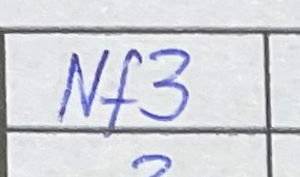

In [15]:

image = Image.open('chessreaderdata/images/131.png').convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Nf3


In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [18]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [19]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [20]:
from datasets import load_metric

cer_metric = load_metric("cer")

/var/folders/20/2kn9rjns09d18w17wc_48kr00000gn/T/ipykernel_14597/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [21]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [22]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

model.save_pretrained(".")   

/Users/aminebelghmi/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/405 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 16%|█▌        | 64/405 [2:33:18<13:36:49, 143.72s/it]


KeyboardInterrupt: 